In [2]:
import tensorflow as tf
import os 
import numpy as np
from matplotlib import pyplot as plt
AUTOTUNE = tf.data.AUTOTUNE

In [3]:
# Dataset Constants
DATASET_PATH = "./recordbase"
TRAIN_DIR = "train"
VAL_DIR = "val"
TEST_DIR = "test"

RECORD_ENCODING_TYPE = "ZLIB" # none if no encoding is used

# Pipeline parameters
buffer_size = None # set buffer size to default value, change if you have bottleneck
batch_size = 32
shuffle_size = 256 # because dataset is too large huge shuffle sizes may cause problems with ram
epochs = 1
steps_per_epoch = 50

In [4]:
# helper function for data visualization
def visualize(**images):
    """Plot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        image[1,1] = 0 
        plt.imshow(image)
    plt.show()

def visualize_dataset(img, mask, classes):
    kwarg = {'image': img}
    for i in range(len(classes)):
        kwarg.update({classes[i] : mask[..., i].squeeze()})
    visualize(**kwarg)

In [5]:
def parse_tfrecord_fn(example):
    feature_description = {
        'image/height' : tf.io.FixedLenFeature([], tf.int64),
        'image/width' : tf.io.FixedLenFeature([], tf.int64),
        'image/depth' : tf.io.FixedLenFeature([], tf.int64),
        'image/raw_image' : tf.io.FixedLenFeature([], tf.string),
        'label/raw' : tf.io.FixedLenFeature([], tf.string)
    }
    
    example = tf.io.parse_single_example(example, feature_description)
    return example

def parse_examples_batch(examples):
    feature_description = {
        'image/height' : tf.io.FixedLenFeature([], tf.int64),
        'image/width' : tf.io.FixedLenFeature([], tf.int64),
        'image/depth' : tf.io.FixedLenFeature([], tf.int64),
        'image/raw_image' : tf.io.FixedLenFeature([], tf.string),
        'label/raw' : tf.io.FixedLenFeature([], tf.string)
    }
    samples = tf.io.parse_example(examples, feature_description)
    return samples

def prepare_sample(features):
    #image = tf.io.parse_tensor(features["image/raw_image"], out_type=tf.uint8)
    #image = tf.reshape(image, shape=[features['image/height'], features['image/width'], 3])
    #label = tf.io.parse_tensor(features["label/raw"], out_type=tf.double)
    image = tf.vectorized_map(lambda x: tf.io.parse_tensor(x, out_type = tf.uint8), features["image/raw_image"])
    label = tf.vectorized_map(lambda x: tf.io.parse_tensor(x, out_type = tf.double), features["label/raw"])
    #label = tf.reshape(label, shape=[features['image/height'], features['image/width'], 3])
    #image = tf.image.resize(features["image/raw_image"], size=(features['image/height'], features['image/width']))
    #label = tf.image.resize(features["label/raw"], size=(features['image/height'], features['image/width']))
    return image, label


def get_dataset(filenames, batch_size):
    dataset = (
        tf.data.TFRecordDataset(filenames, compression_type=RECORD_ENCODING_TYPE, num_parallel_reads=AUTOTUNE)
        .map(parse_tfrecord_fn, num_parallel_calls=AUTOTUNE)
        .map(prepare_sample, num_parallel_calls=AUTOTUNE)
        .shuffle(batch_size * 10)
        .batch(batch_size)
        .prefetch(AUTOTUNE)
    )
    return dataset

def get_dataset_optimized(filenames, batch_size, shuffle_size):
    return (tf.data.TFRecordDataset(filenames, compression_type=RECORD_ENCODING_TYPE, num_parallel_reads=AUTOTUNE)
    .shuffle(shuffle_size) # maybe change this to batch_size * 10
    .batch(batch_size=batch_size)
    .map(map_func=parse_examples_batch, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    .map(map_func=prepare_sample, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    .cache()
    .prefetch(tf.data.experimental.AUTOTUNE))

In [6]:
train_dir = os.path.join(DATASET_PATH, TRAIN_DIR)
val_dir = os.path.join(DATASET_PATH, VAL_DIR)

train_filenames = tf.io.gfile.glob(f"{train_dir}/*.tfrecords")
val_filenames = tf.io.gfile.glob(f"{val_dir}/*.tfrecords")

test_data = get_dataset_optimized(train_filenames, batch_size, shuffle_size)

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


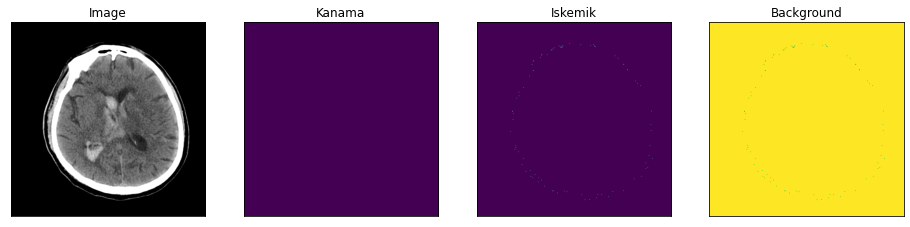

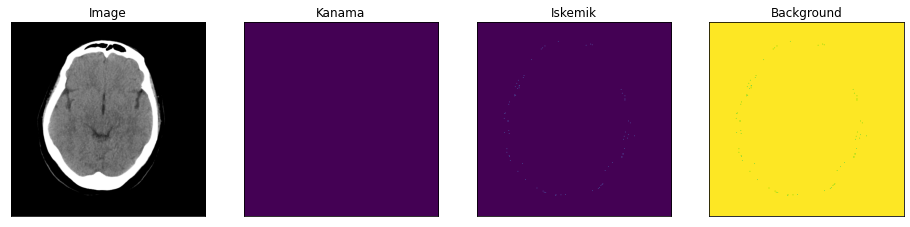

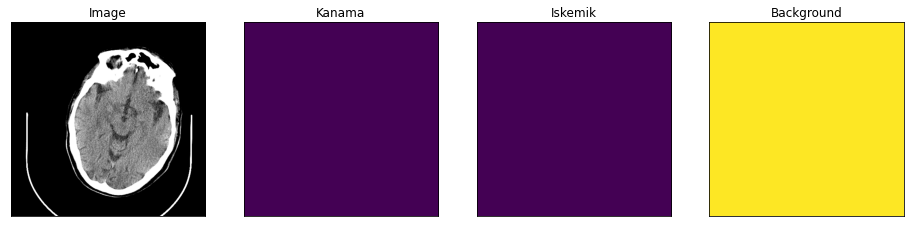

In [30]:
i = test_data.take(1)
for x in i:
    for k in range(2, 5):
        img, mask = x
        visualize_dataset(img[k].numpy(), mask[k].numpy(), ["kanama", "iskemik", "background"])